## Plotting globally distributed earthquakes on a map with equidistant projection

Feel free to modify or play around with the different parameters!

**PyGMT and GMT requirements history:**
* 2020-04-13 (original version): PyGMT [0.1.0](https://www.pygmt.org/v0.1.0/index.html) & GMT >= [6.0.0](https://docs.generic-mapping-tools.org/6.0/)
* 2023-06-25: PyGMT [0.9.0](https://www.pygmt.org/v0.9.0/index.html) & GMT >= [6.3.0](https://docs.generic-mapping-tools.org/6.3/)
* 2025-07-04 (last modified): PyGMT [0.16.0](https://www.pygmt.org/v0.16.0/index.html) & GMT >= [6.4.0](https://docs.generic-mapping-tools.org/6.4/)

**Additional required packages:**
* numpy
* pandas
* [ObsPy](https://github.com/obspy/obspy/wiki)
* geographiclib
* seaborn (only if you want to visualize the raw data as histogram)

**Author:**
* Michael Grund ([@michaelgrund](https://github.com/michaelgrund))

In [1]:
import pygmt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from obspy.geodetics.base import gps2dist_azimuth

# define foreground color that is later used for plotting
pygmt.config(COLOR_FOREGROUND = "red3")

Earthquake data is freely available from USGS and can be easily downloaded via `pandas` (for more information on earthquake data take a look on: <https://earthquake.usgs.gov/earthquakes/map/>).

Define the time period (here 1960/01/01 to 2025/07/03), magnitude range (here >= 6), ordering of the requested data and build an url (`urlfin`) that can be directly handed over to pandas `read_csv` function. The requested earthquake data is then stored in `data_raw`.

In [2]:
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query.csv'
time = 'starttime=1960-01-01%2000:00:00&endtime=2025-07-03%2000:00:00'
mag = 'minmagnitude=6'
order = 'orderby=time-asc'
urlfin = url + '?' + '&'.join([time, mag, order])

# use pandas to fetch the file from the USGS webserver via the url built above
data_raw = pd.read_csv(urlfin)
# create year column from date for later visualization
data_raw["year"] = pd.DatetimeIndex(data_raw["time"]).year

Let's take a look into the raw data:

In [3]:
data_raw

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,year
0,1960-01-02T12:21:58.720Z,-55.8770,-1.8900,15.000,6.31,mw,NaN,NaN,NaN,NaN,...,Bouvet Island region,earthquake,NaN,25.000,0.370,NaN,reviewed,iscgem,iscgem,1960
1,1960-01-04T06:16:35.900Z,11.3740,42.6090,15.000,6.07,mw,NaN,NaN,NaN,NaN,...,"26 km NNW of 'Ali Sabieh, Djibouti",earthquake,NaN,25.000,1.070,NaN,reviewed,iscgemsup,iscgemsup,1960
2,1960-01-07T13:28:20.150Z,-55.5910,-27.2780,35.000,6.23,mw,NaN,NaN,NaN,NaN,...,South Sandwich Islands region,earthquake,NaN,25.000,0.200,NaN,reviewed,iscgem,iscgem,1960
3,1960-01-08T14:46:02.020Z,-55.5850,-27.4750,35.000,6.01,mw,NaN,NaN,NaN,NaN,...,South Sandwich Islands region,earthquake,NaN,25.000,0.220,NaN,reviewed,iscgem,iscgem,1960
4,1960-01-12T03:09:17.910Z,-55.6670,-27.1350,35.000,6.04,mw,NaN,NaN,NaN,NaN,...,South Sandwich Islands region,earthquake,NaN,11.300,0.200,NaN,reviewed,iscgem,iscgem,1960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,2025-06-21T21:23:18.685Z,42.9614,146.4812,18.000,6.00,mww,138.0,41.0,2.634,1.00,...,"83 km ESE of Nemuro, Japan",earthquake,8.19,1.753,0.055,32.0,reviewed,us,us,2025
8946,2025-06-24T01:58:05.961Z,7.9876,129.8586,5.000,6.20,mww,174.0,34.0,4.340,0.74,...,east of the Philippine Islands,earthquake,7.52,1.730,0.055,32.0,reviewed,us,us,2025
8947,2025-06-25T22:16:15.483Z,-35.5606,-17.1168,10.000,6.20,mww,71.0,57.0,4.159,1.05,...,southern Mid-Atlantic Ridge,earthquake,10.54,1.868,0.052,36.0,reviewed,us,us,2025
8948,2025-06-27T23:07:10.186Z,5.2772,126.0977,101.614,6.10,mww,117.0,27.0,0.820,1.20,...,"71 km ESE of Sarangani, Philippines",earthquake,6.58,5.778,0.048,41.0,reviewed,us,us,2025


There are different types of magnitudes included in the data:

<Axes: xlabel='mag', ylabel='Count'>

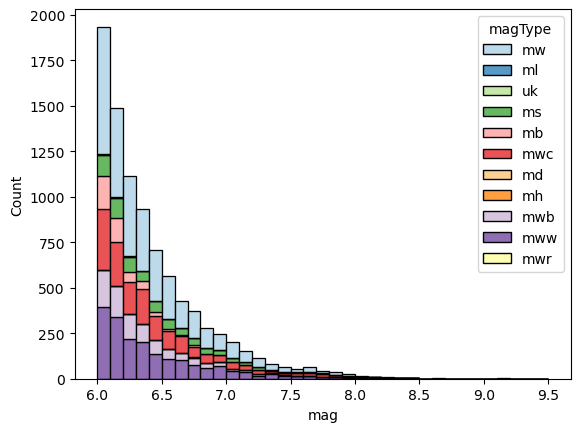

In [4]:
sns.histplot(data = data_raw, x = "mag", hue = "magType", multiple = "stack", palette = "Paired", binwidth = .1)

Let's explore how the data developed over time (per year):

<Axes: xlabel='year', ylabel='Count'>

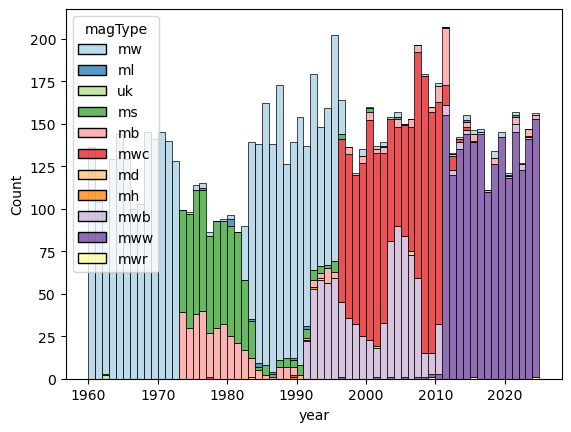

In [5]:
sns.histplot(data = data_raw, x = "year", hue = "magType", multiple = "stack", palette = "Paired", binwidth = 1)

In the following we will only keep moment magnitude data (containing any "mw" in the "magType" column) although the individual definitions differ slightly (for the definitions see [here](https://www.usgs.gov/programs/earthquake-hazards/magnitude-types)). Interestingly, in the last decade the majority of magnitudes in the data set have been determined based on centroid moment tensor inversion of the W-phase:

In [6]:
data = data_raw[data_raw["magType"].str.contains("mw")].copy().reset_index(drop = True)

Create a new pygmt figure object.

In [7]:
fig = pygmt.Figure()

Let's start with the basic map in a global equidistant projection (`"E"`) with a horizon limit at 160° distance and a diameter of 5.8i centered at `centerE`/`centerN`. In this example the center location corresponds to the Black Forest Observatory in southwestern Germany, one of the most quiet seismic stations around the globe ;) (see <http://www.black-forest-observatory.de/>).

* Continents are plotted in gray color as defined by `colfill` (RGB values). 
* Resolution of the continents is set to `"c"` (crude) and only shorelines of the first level (coastline) are plotted with a linewidth of 0.1p (`"1/0.1p"`). See <https://www.pygmt.org/dev/tutorials/basics/coastlines.html> for other supported resolutions and shoreline levels. 
* `lakes` defines the color of wet areas which is set here to the same color as the continents have, so no lakes and rivers are visible.

coast [WARNING]: Fill/clip continent option (-G) may not work for this projection.
coast [WARNING]: If the antipode (3.04771e-314/0) is in the ocean then chances are good it will work.
coast [WARNING]: Otherwise, avoid projection center coordinates that are exact multiples of 188.331 degrees.


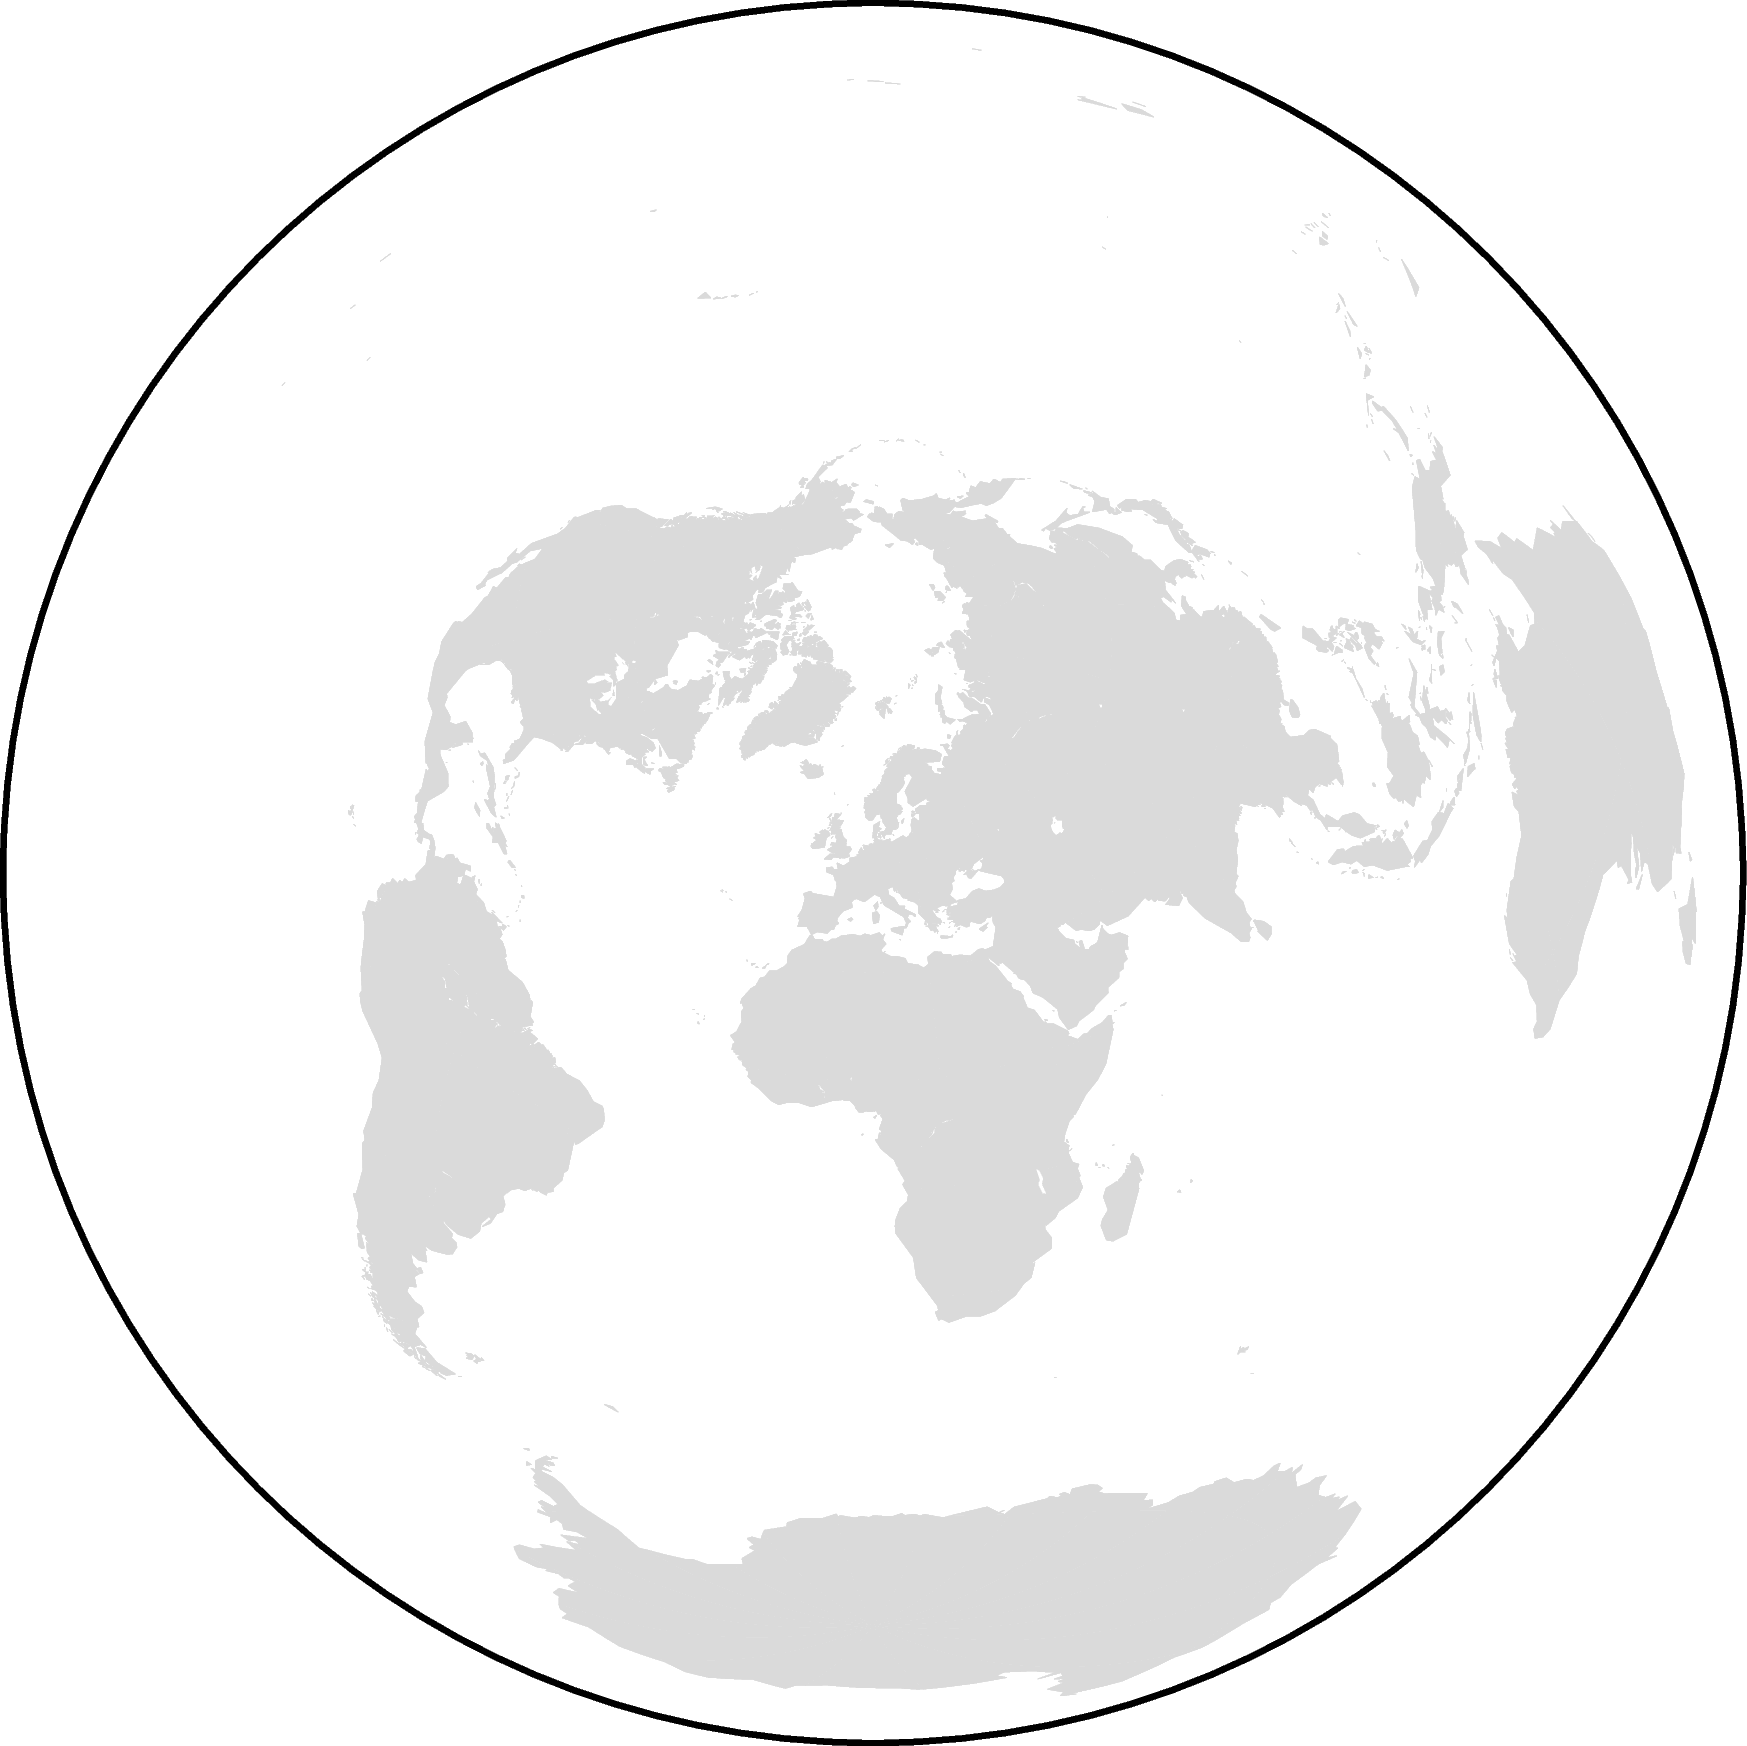

In [8]:
# center of map
centerN = 48.332 # latitude in degrees
centerE = 8.331 # longitude in degrees

colfill = "217.6/217.6/217.6"
fig.coast(region = "g", 
          projection = "E" + str(centerE) + "/" + str(centerN) + "/160/5.8i", 
          resolution = "c", 
          land = colfill, 
          shorelines = "1/0.1p," + colfill, 
          lakes = colfill, 
          frame = True)

fig.show()

Now let's add the following items:
* The plate boundaries after Bird (2003) as light red lines of 0.5 p thickness (`pen = "0.5p," + plbcol`), read from a simple texfile (`data = plbfile`)
* Dashed circles within a specified distance (in °) from the map center (`distlims`)  
* A darkgray (`fill = "105/105/105"`) triangle with a size of 0.65 cm (`style = "t0.65c"`) and a black edge of 0.7p thickness (`pen = "0.7p,black"`) in the map center representing e.g. a station network or a single seismic recording station

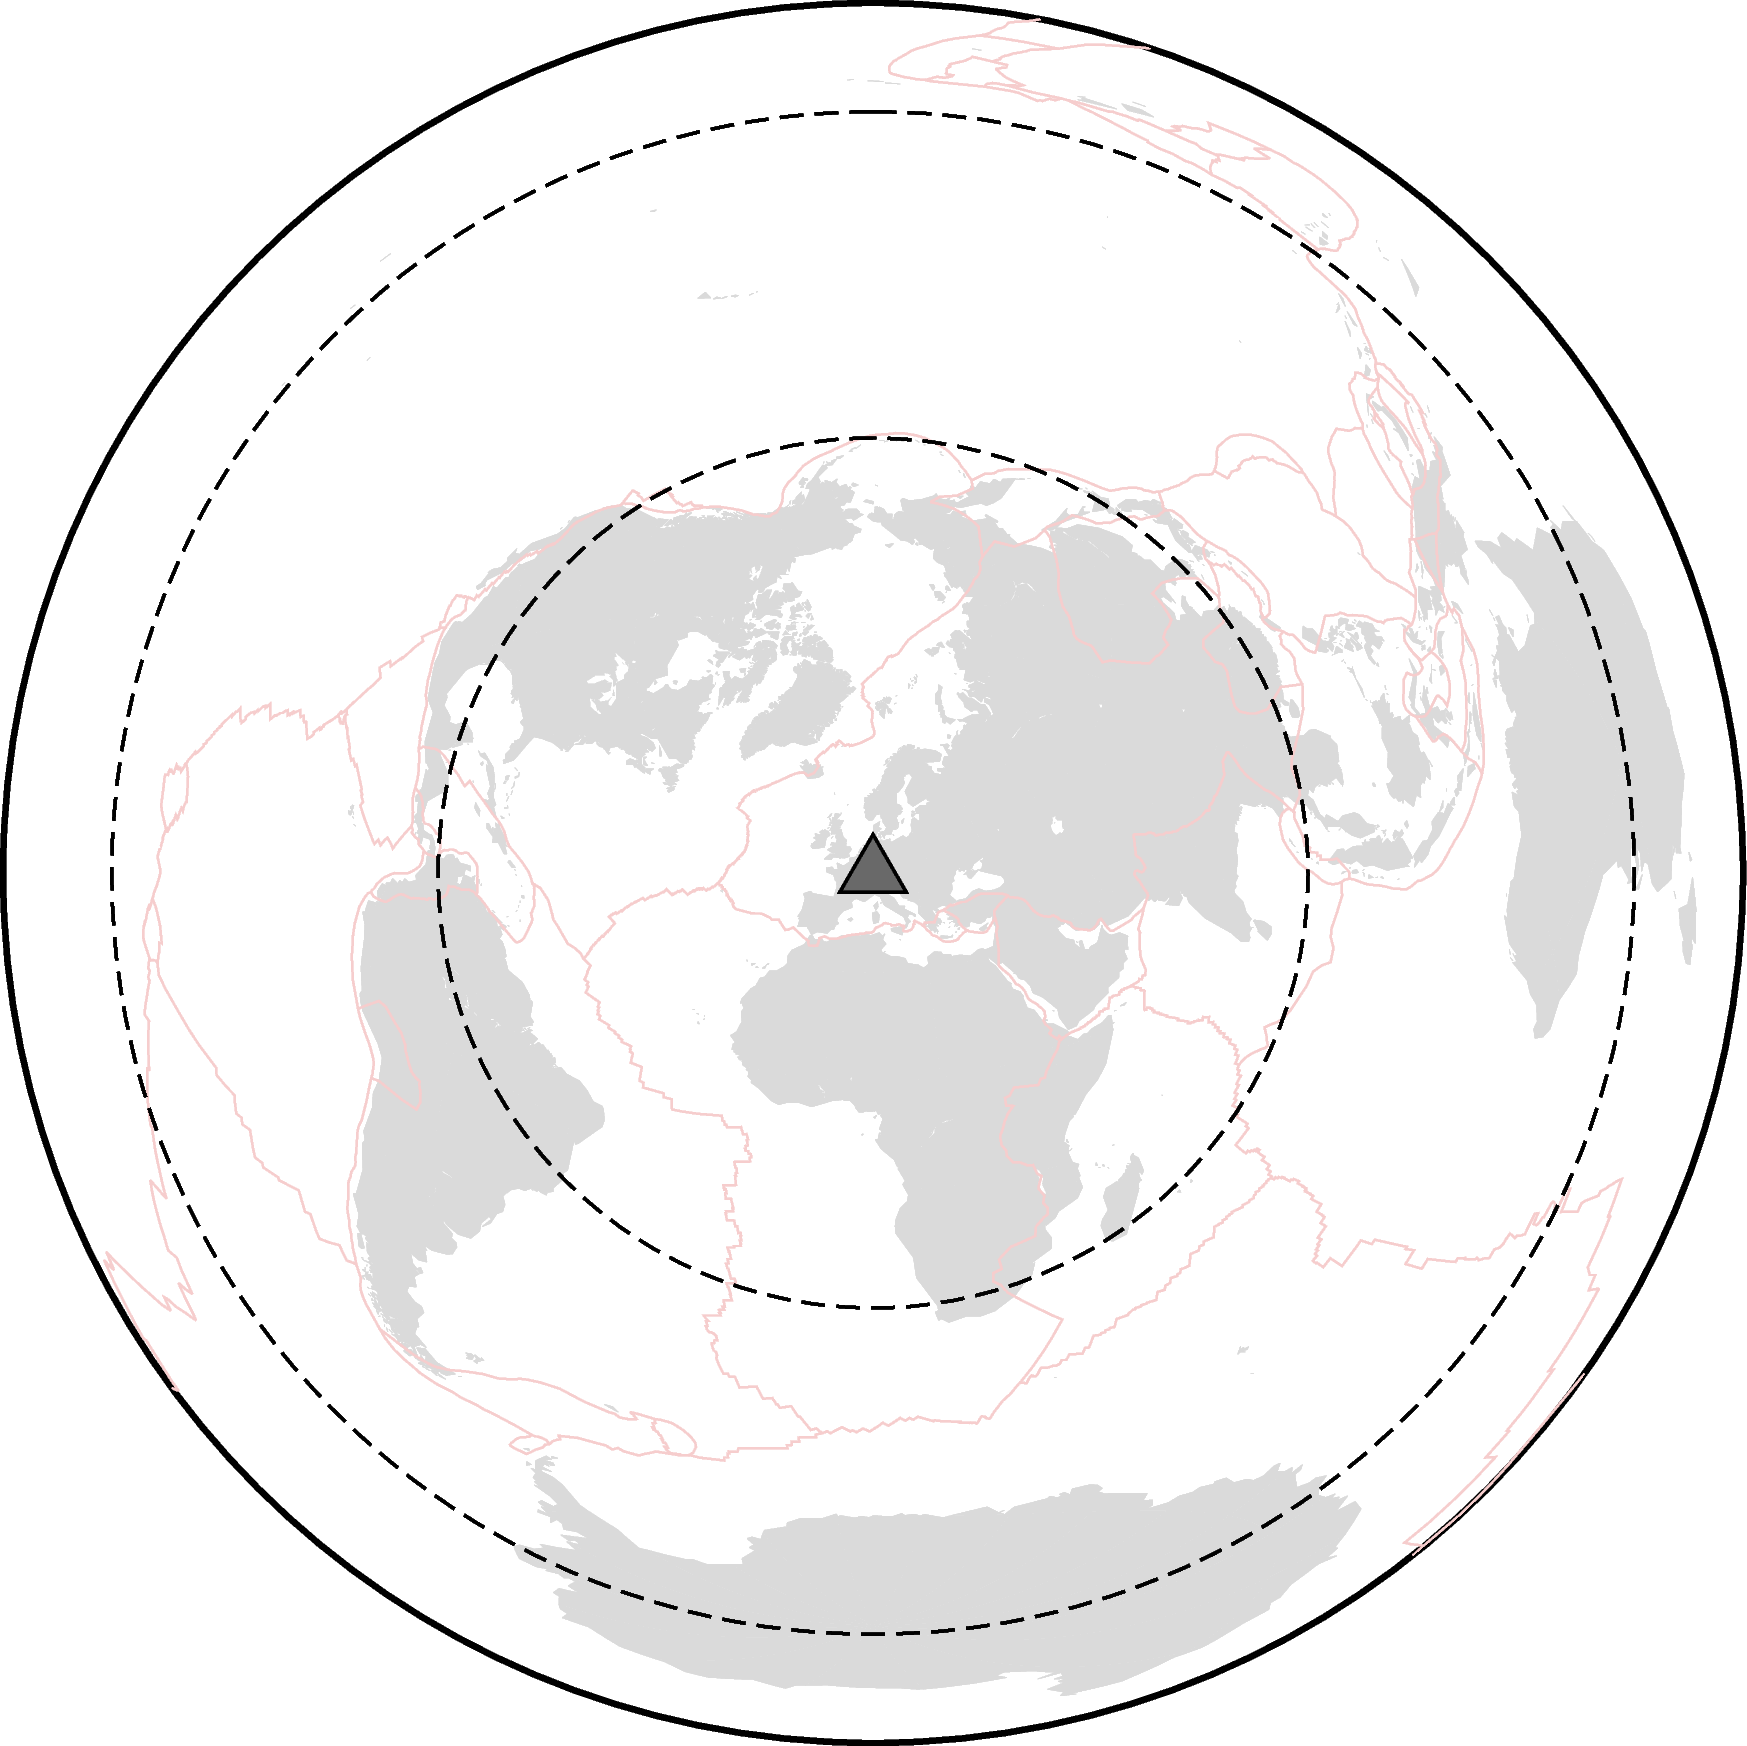

In [9]:
# plot plate boundaries after Bird (2003)
plbfile = "PB2003_boundaries_GMTready.txt"
plbcol = "245.76/204.8/204.8"
fig.plot(data = plbfile, pen = "0.5p," + plbcol)

# plot circles at 80 and 140 degrees distance, use here twice the value since GMT expects the diameter
distlims = [80, 140]

for lims in distlims:
    fig.plot(x = centerE, 
             y = centerN, 
             style = "E-" + str(2 * lims) + "d", 
             pen = "0.7p,black,--")

# plot station marker
fig.plot(x = centerE, 
         y = centerN, 
         fill = "105/105/105", 
         style = "t0.65c", 
         pen = "0.7p,black")

fig.show()

* Now we first define the colormap that should be used. Here we take the continuous `viridis` colormap for events with depths between 0 and 600 km and a step size of 100 km (defined as series). The output colormap is saved as `"cmapmod.cpt"`. `overrule_bg = True` ensures that the foreground color defined in the beginning (`COLOR_FOREGROUND = "red3"`) is used. Thus, all events located deeper than 600 km are plotted in red.

* Afterwards we first calculate the distance for each earthquake epicenter location to the map center using ObsPy's `ps2dist_azimuth` function (at a later stage of development this action may be done directly using PyGMT, look for mapproject) and store only these events in `datafilt`.

* Finally, we plot the earthquake epicenters within the defined distance range, color-coded by depth and scaled by the event magnitude. 

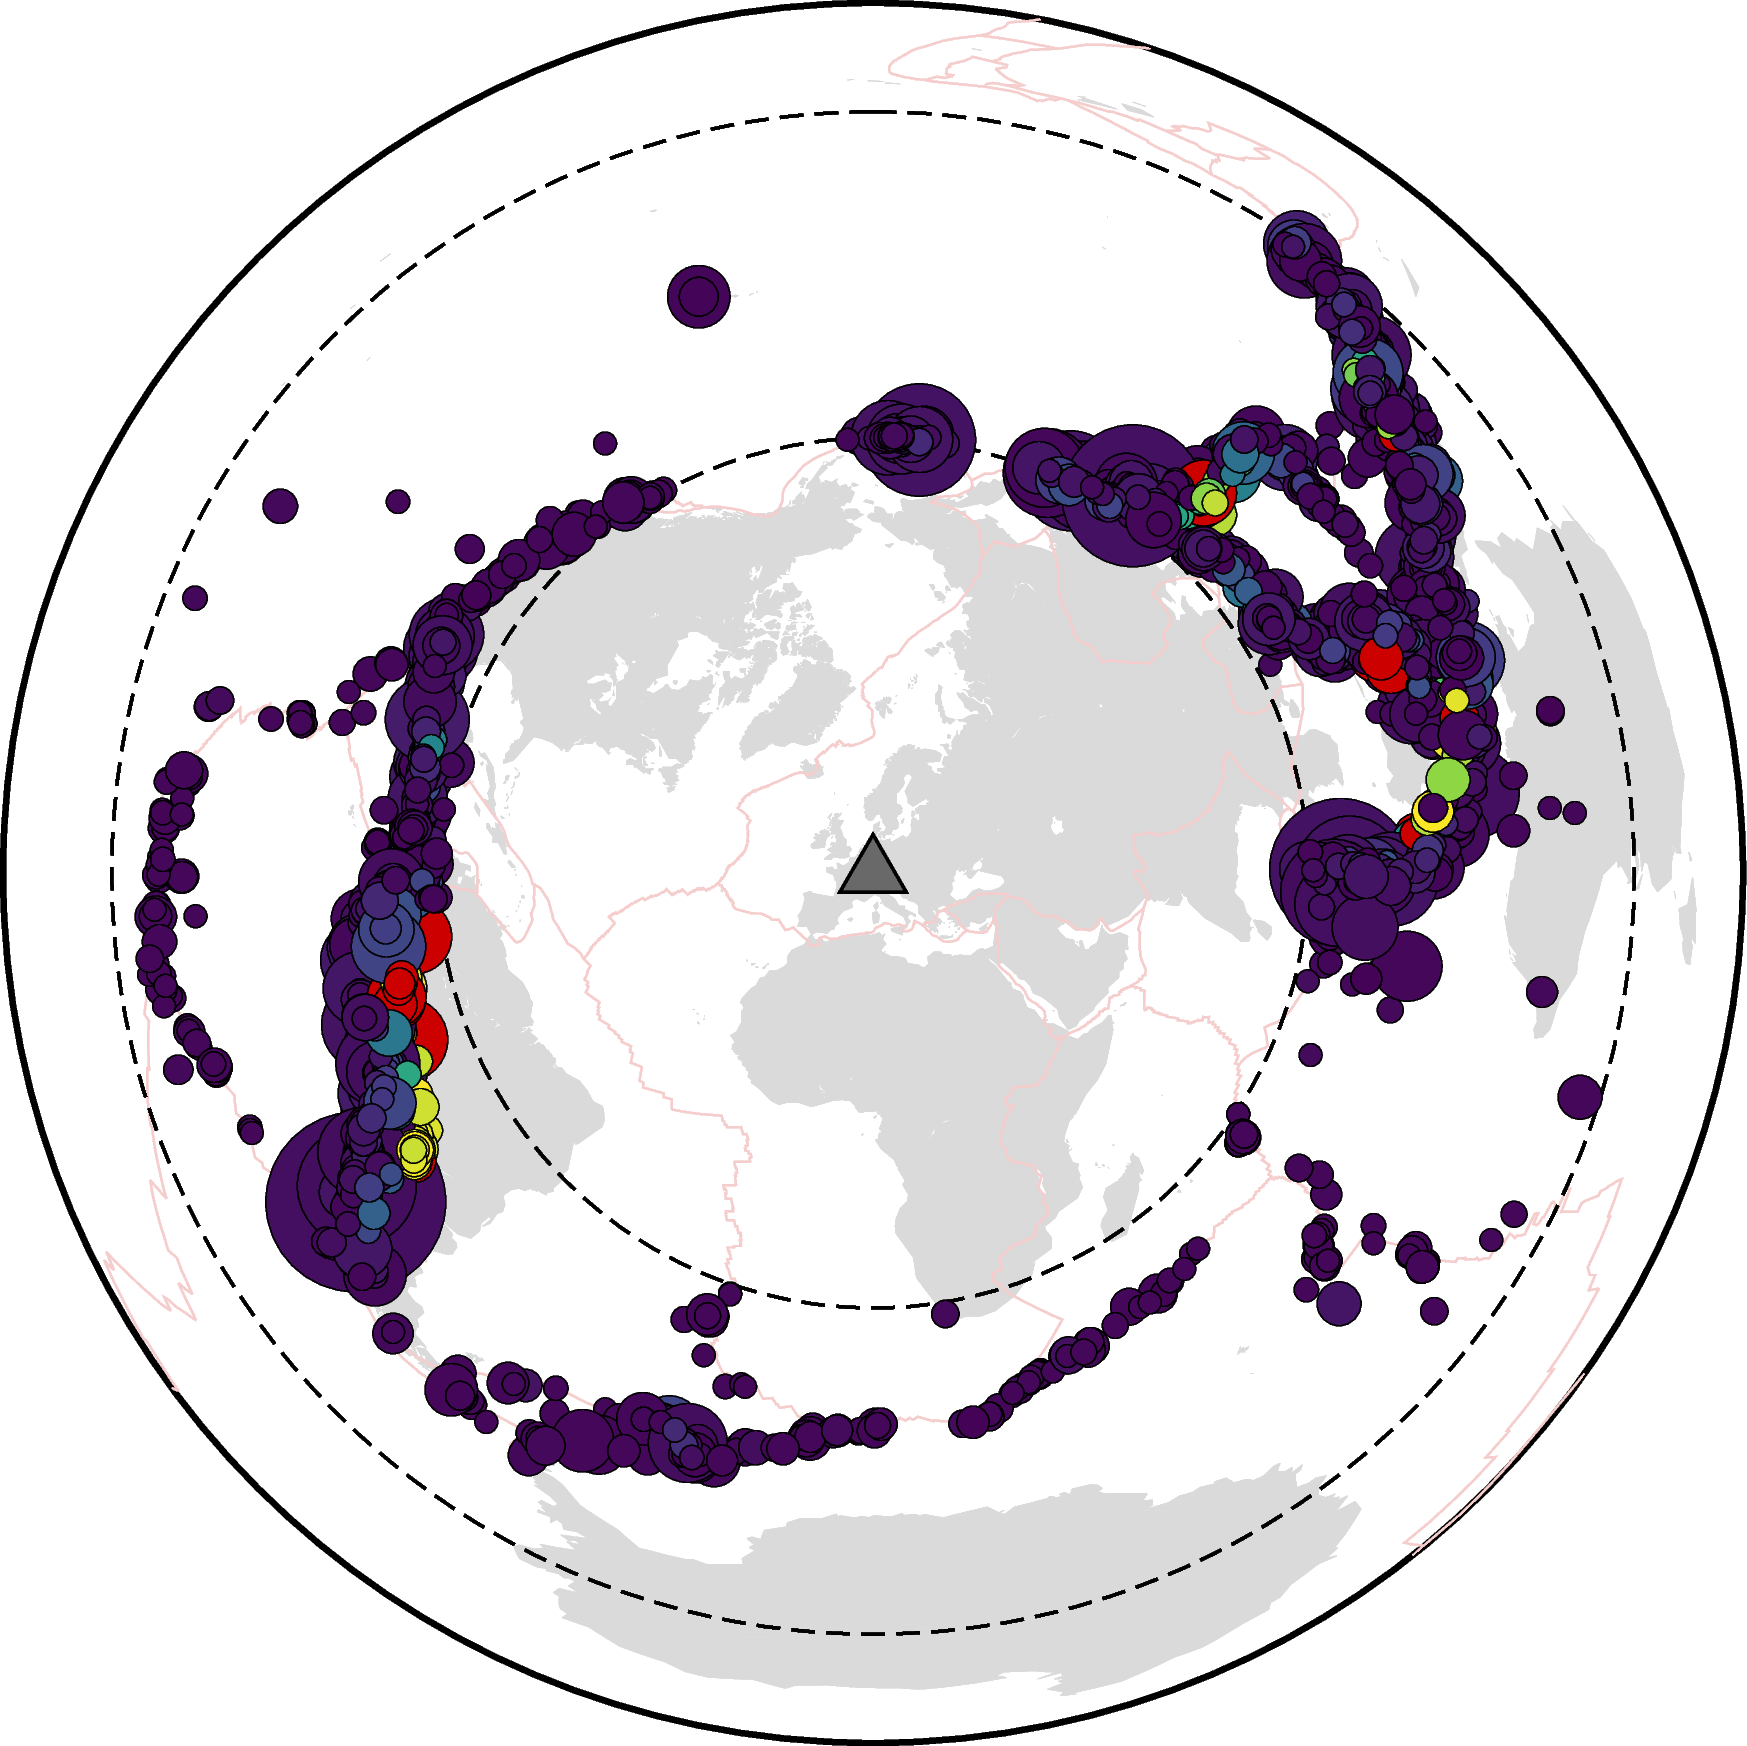

In [10]:
# Define colormap, set reverse = True if you want to reverse the colormap
pygmt.makecpt(cmap = "viridis", 
              reverse = False, 
              series = [0, 600, 100], 
              output = "cmapmod.cpt", 
              continuous = True,  
              overrule_bg = True)

cwd = os.getcwd()

# calculate distance from each EQ to center of map, later this may be available in pygmt as psproject,
# instead use obspy now
data['isin'] = np.full(np.shape(data)[0], False) # generate new column in dataframe filled with False

for ii in range(0,len(data)):
    if distlims[0] < gps2dist_azimuth(centerN, centerE, data["latitude"][ii], data["longitude"][ii])[0]/111/1000 < distlims[1]:
        data.at[ii, "isin"] = True


# use only EQs within the given distance range     
datafilt = data[data["isin"] == True].copy() 

# plot the corresponding event locations
fig.plot(x = datafilt.longitude, 
         y = datafilt.latitude, 
         style = "c" , 
         pen = "black",
         size = np.exp(datafilt.mag / 1.7) * 0.0057, 
         fill = datafilt.depth, 
         cmap = cwd + "/cmapmod.cpt")

fig.show() 

1) Plot the distance circles for the values given in `distlims` again on top in white with slight transparency (`transparency = "60"`). This small trick ensures that the circles are also visible when the "event circles" overlap

2) Add text to the distance circles and place a colorbar in upper left corner. 
* The position of the colorbar is 0.2 cm in x-  and 15.7 cm in y-direction direction from the origin in the lower left corner (`x0.2c/15.7c`) 
* The size is given by a width of 6.5 cm and a height of 0.45 cm (`w6.5c/0.45c`)
* The white triangle on the right-hand side of the bar is defined by `ef0.2c`
* Locating the label defined in `frame` above the colorbar is handled by `ml`
* The horizontal orientation of the colorbar is set by `h`

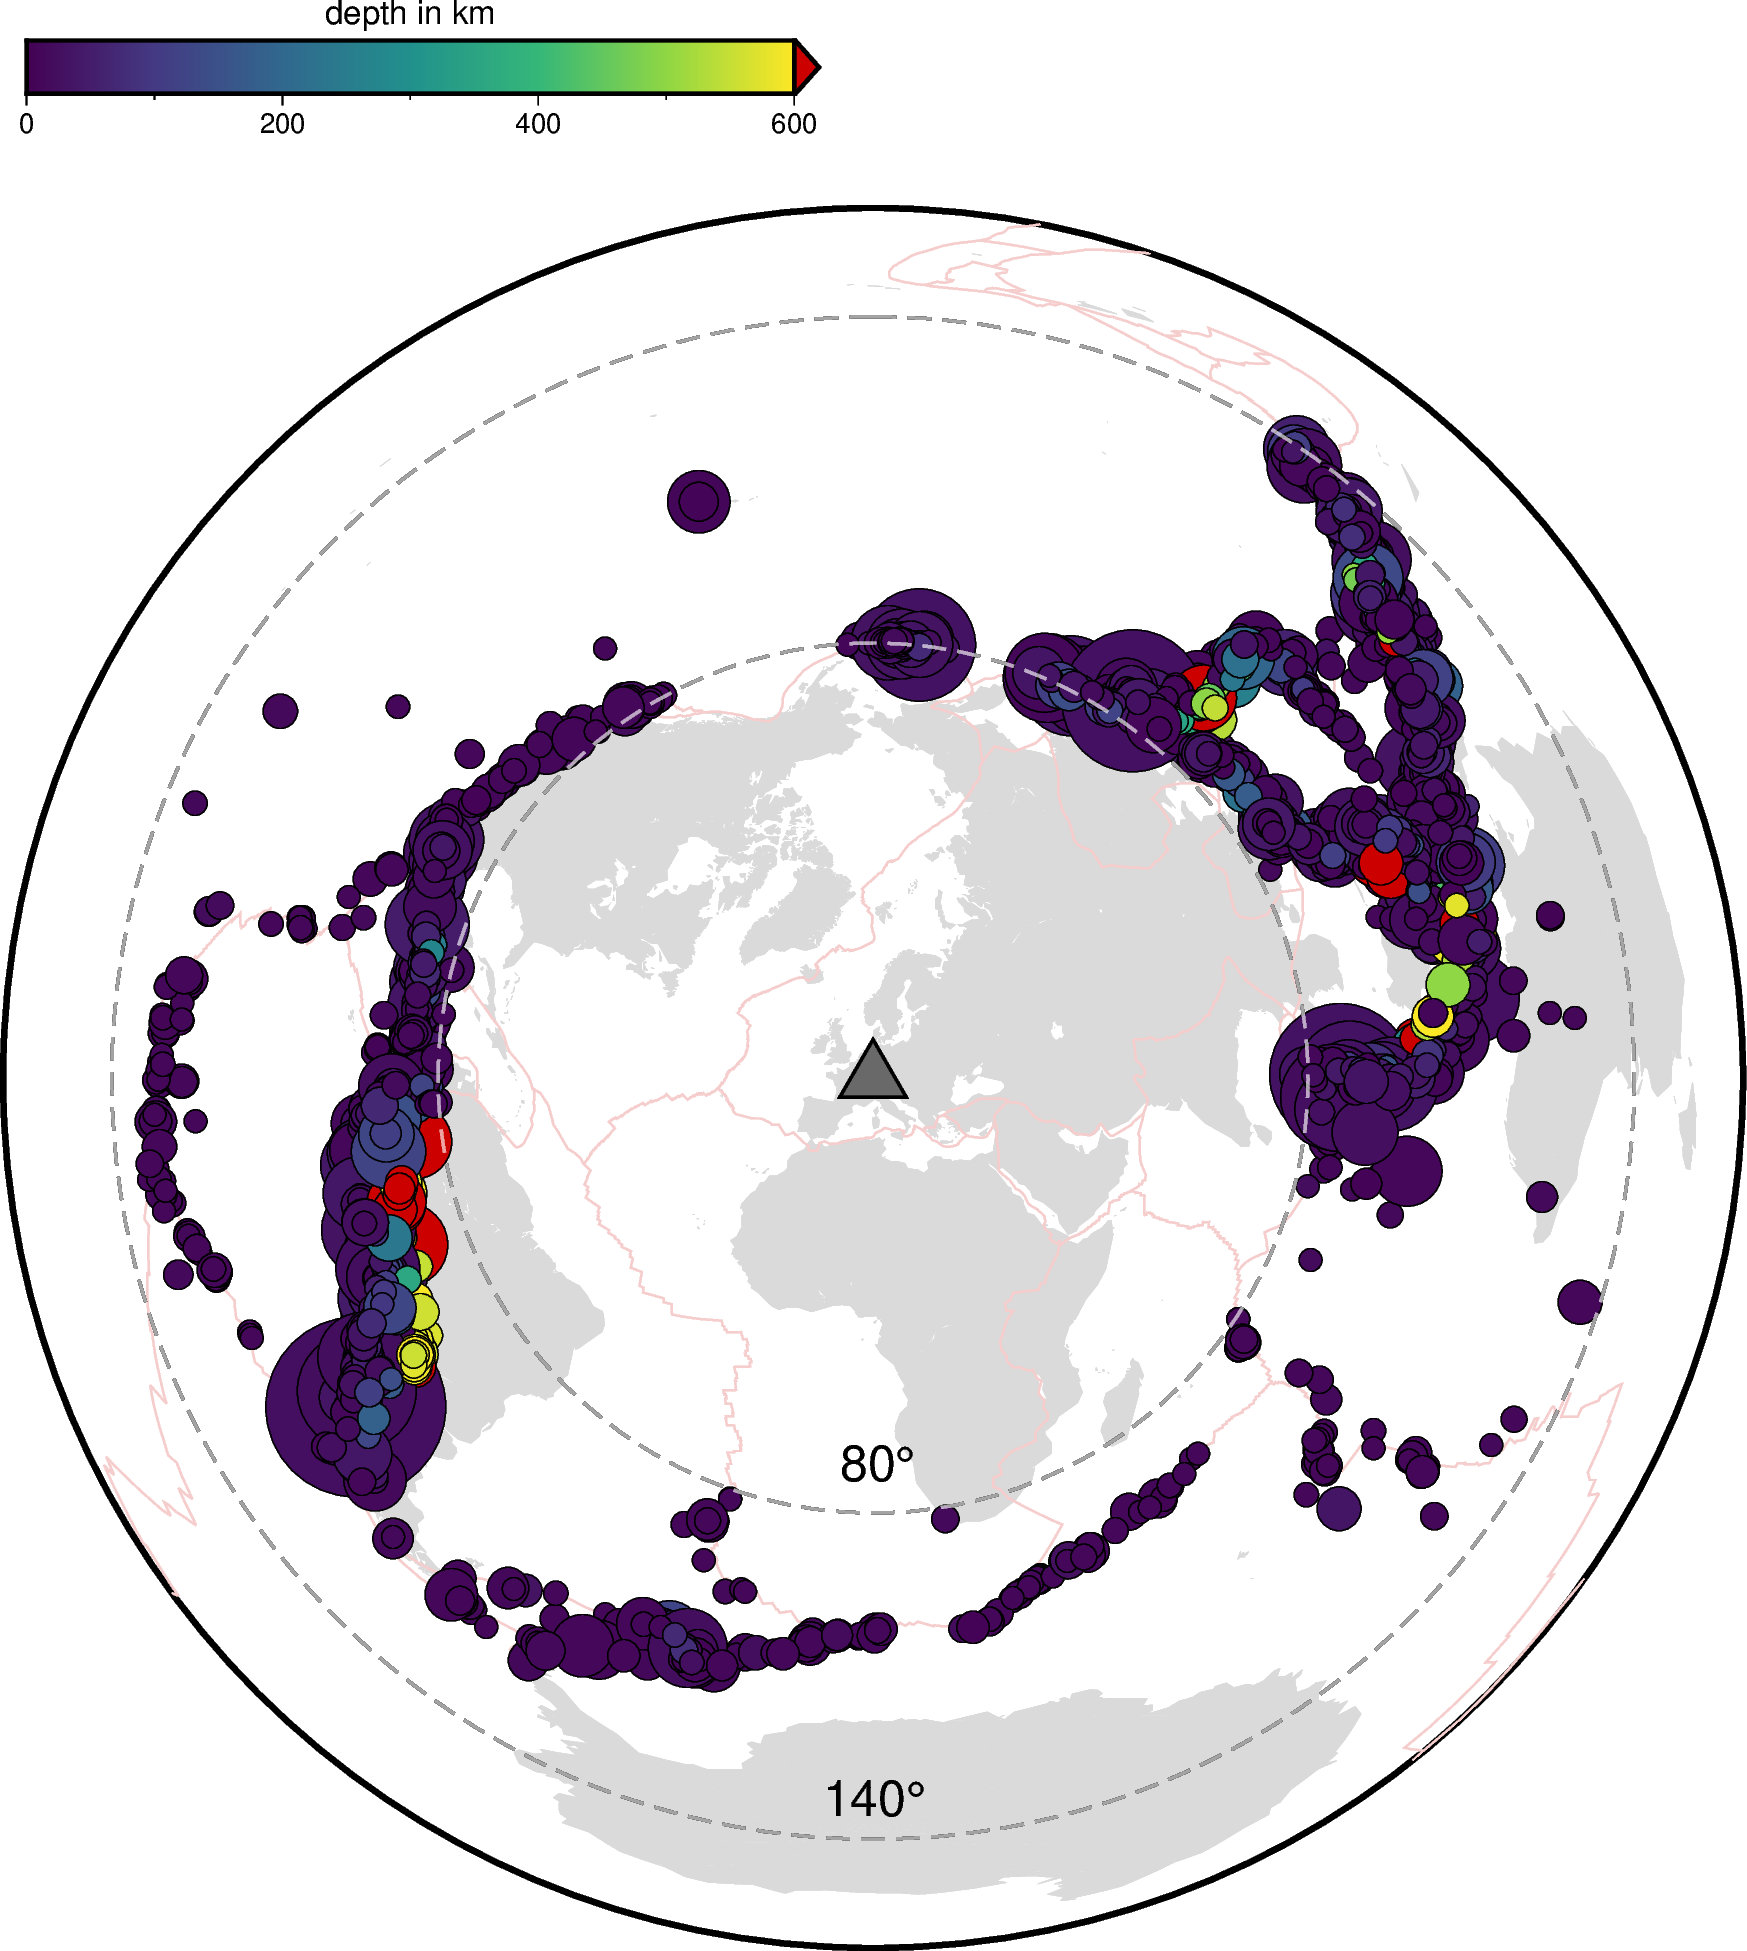

In [11]:
# plot distance circles again on top in transparent white
for lims in distlims:
    fig.plot(x = centerE, 
             y = centerN, 
             style = "E-" + str(2 * lims) + "d", 
             pen = "0.7p,white,--", 
             transparency = "60")
    
# plot text on circles
fig.text(x = 9, 
         y = -22.5, 
         text = "80@.", 
         font = "12p")

fig.text(x = 9, 
         y = -84, 
         text = "140@.", 
         font = "12p")

# set fontsize of label to "12" 
with pygmt.config(FONT_LABEL = "12"):
    fig.colorbar(cmap = cwd + "/cmapmod.cpt", 
                 position = "x0.2c/15.7c+w6.5c/0.45c+ef0.2c+ml+h", 
                 box = False, 
                 frame = ['+Ldepth in km', "xaf"])

fig.show()

Now plot a custom legend showing the magnitudes in the figure as gray circles of different size by using another map projection.

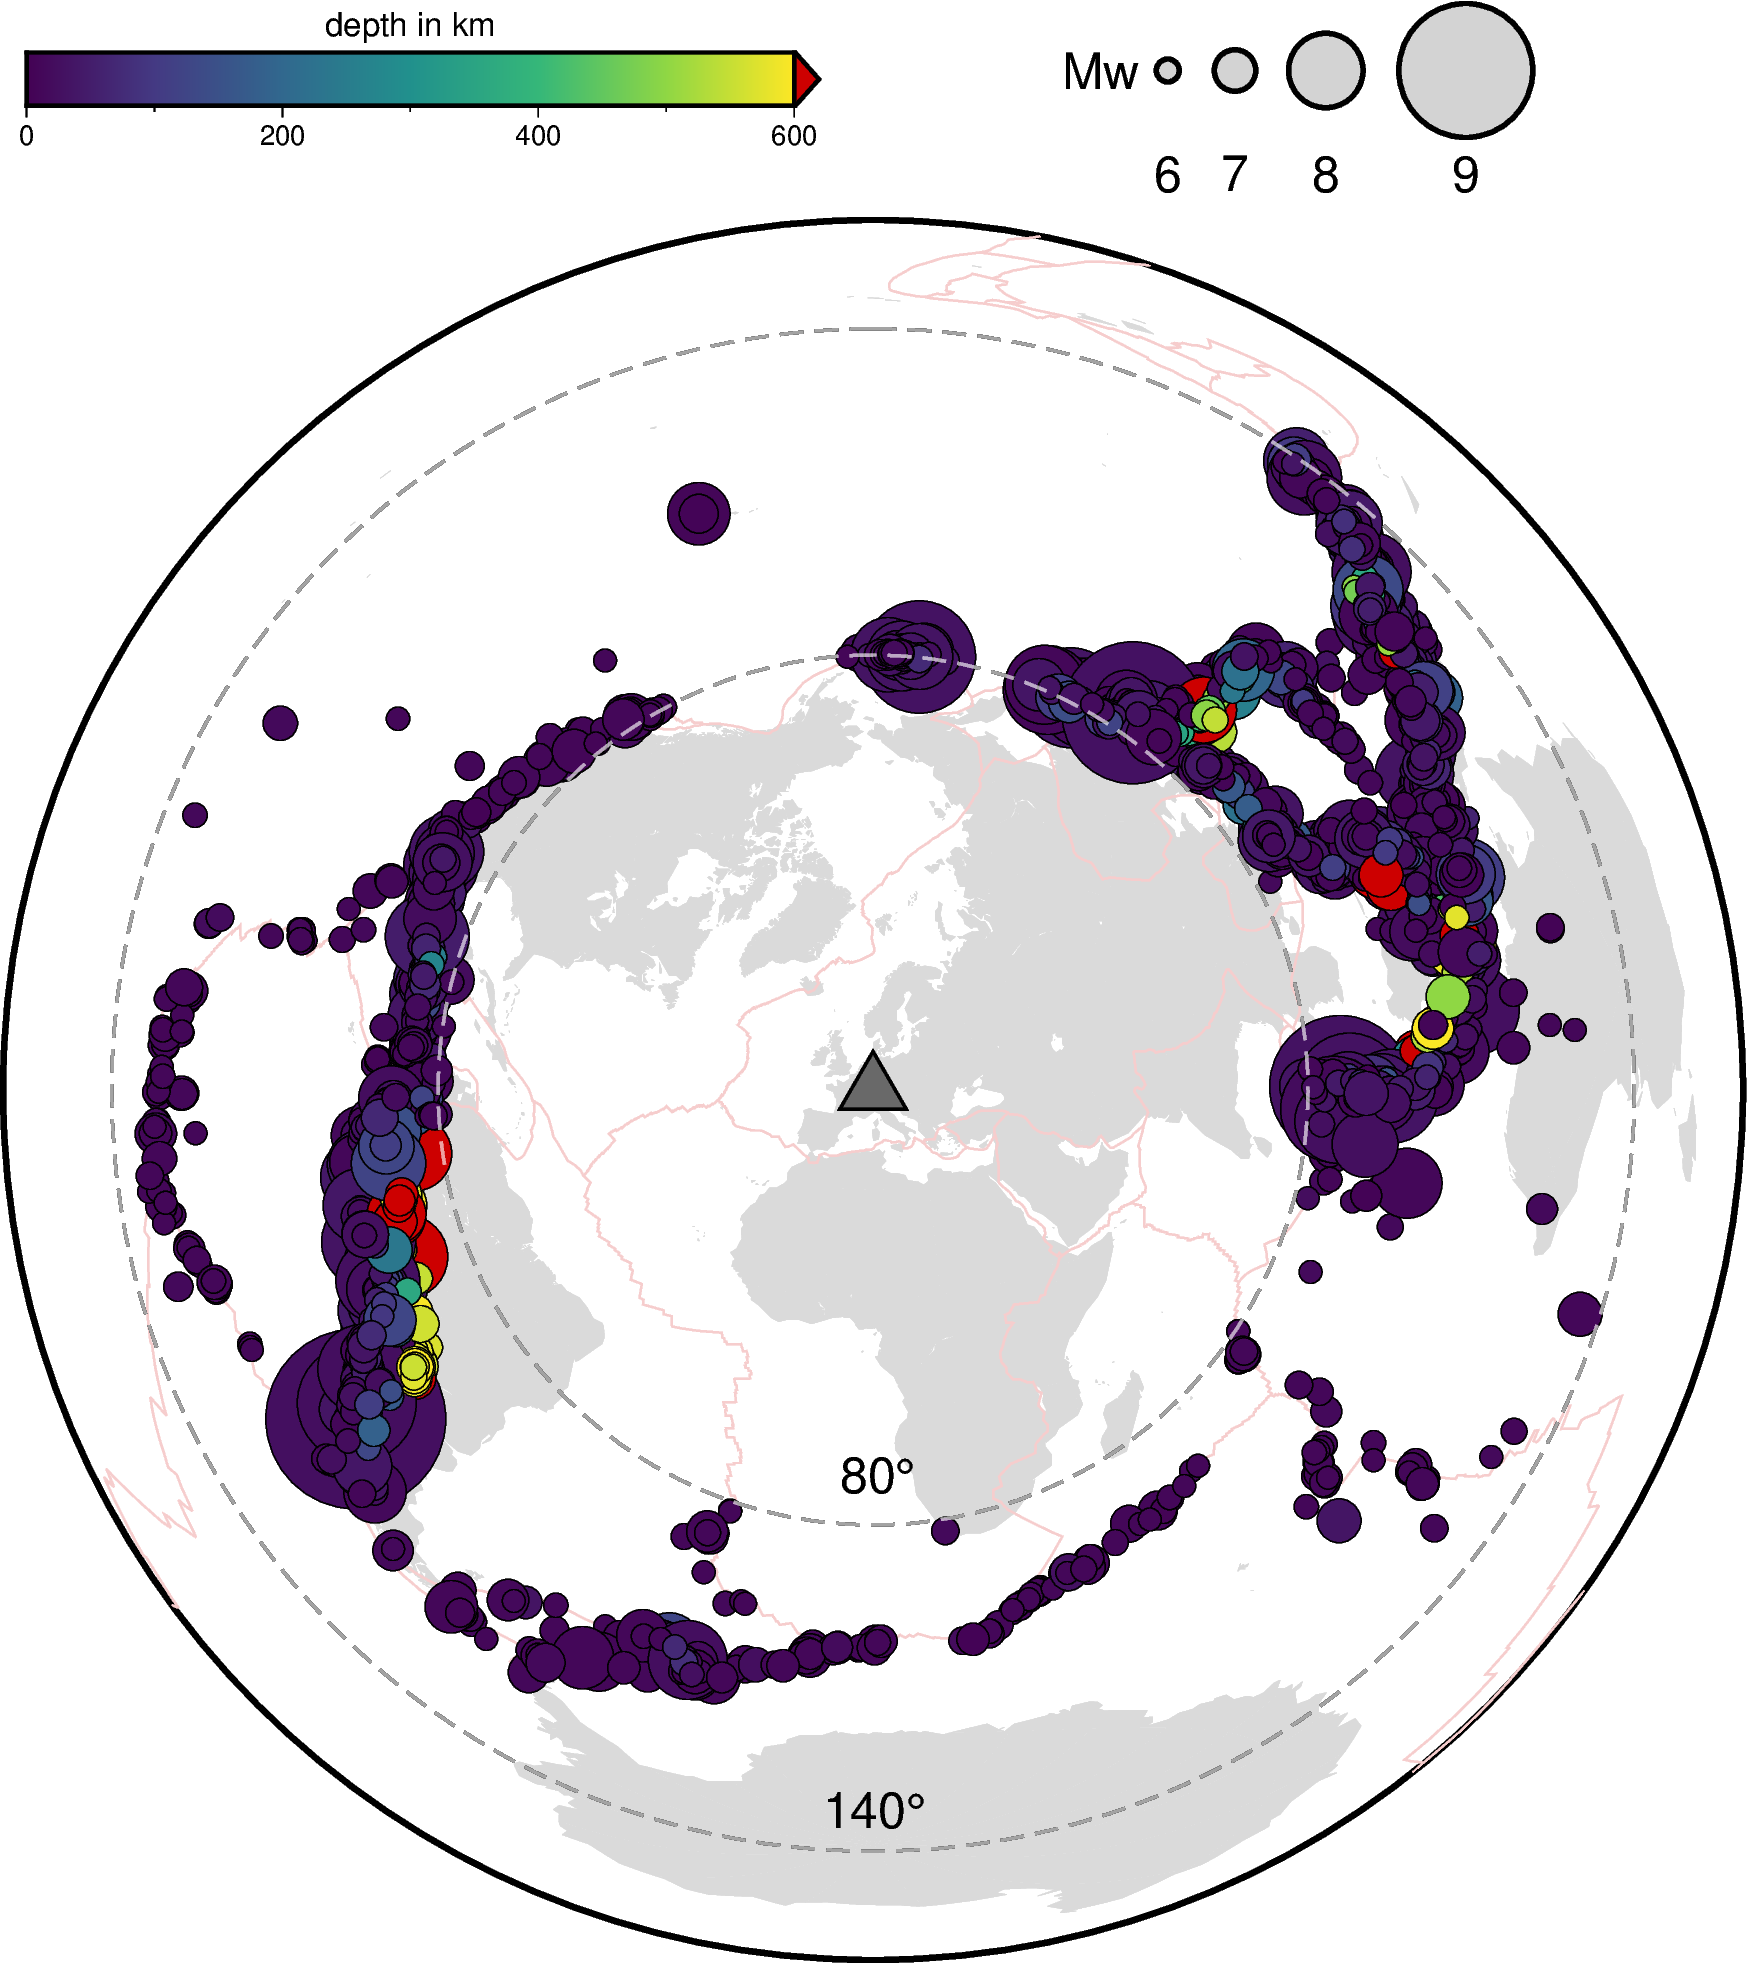

In [12]:
col_leg = "lightgray"

fig.shift_origin(xshift = "9c", yshift = "13.2c")

# plot circles
yval1 = 18
fig.plot(region = [0, 26, 0, 26], projection = "M4", x = 22, y = yval1, style = 'c' + str(np.exp(9 / 1.7) * 0.0057), pen = "1.2p,black", fill = col_leg)
fig.plot(x = 14.3, y = yval1, style = "c" + str(np.exp(8 / 1.7) * 0.0057) , pen = "1.2p,black", fill = col_leg)
fig.plot(x = 9.3, y = yval1, style = "c" + str(np.exp(7 / 1.7) * 0.0057) , pen = "1.2p,black", fill = col_leg)
fig.plot(x = 5.6, y = yval1, style = "c" + str(np.exp(6 / 1.7) * 0.0057) , pen = "1.2p,black", fill = col_leg)

# add annotations
yval2 = 12.5
fontsize = "12p"

fig.text(x = 22 , y = yval2 , text = "9", font = fontsize)
fig.text(x = 14.3 , y = yval2 , text = "8", font = fontsize)
fig.text(x = 9.3 , y = yval2 , text = "7", font = fontsize)
fig.text(x = 5.6 , y = yval2 , text = "6", font = fontsize)
fig.text(x = 1.9 , y = yval1 , text = "Mw", font = fontsize)

fig.show()

Finally, save the figure in png format with a resolution of 300 dpi.

In [13]:
fig.savefig('PLOT_EQglob_BFO.png', dpi = 300)

### References

* Bird (2003), An updated digital model of plate boundaries, Geochemistry Geophysics Geosystems, 4(3), 1027, <https://doi.org/10.1029/2001GC000252>.